In [1]:
from __future__ import division
import numpy as np
import tensorflow as tf
from string import uppercase
from captcha.image import ImageCaptcha

In [2]:
width = 100
height = 60
# charset = '0123456789'
charset = '0123456789' + uppercase
captchaLength = 4
imageSize = width * height
alpha = 1e-3

In [3]:
def getCode():
    return ''.join(map(
        lambda x: charset[x], 
        np.random.randint(0, len(charset), captchaLength)
    ))
captcha = ImageCaptcha(width=width, height=height)

In [4]:
def getData(n = 10):    
    codeList = [getCode() for _ in range(n)]
    imageList = map(lambda code: captcha.generate_image(code), codeList)
    return imageList, codeList

In [5]:
def weight_variable(shape):
    initial = tf.random_normal(shape, stddev=0.01)                                                                                                     
    return tf.Variable(initial)   

In [6]:
def bias_variable(shape):
    initial = tf.random_normal(shape, stddev=0.1)
    return tf.Variable(initial)   

In [7]:
def conv2d(x, W): 
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

In [8]:
def max_pool(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [9]:
def imageToVertor(image):
    """ 将图片转化为向量表示 """
    image = image.convert("L")
    image = np.asarray(image)
    image = image.reshape([width * height]) / 255
    return image

In [10]:
def codeToVertor(code):
    """ 将验证码转化为向量表示 """
    labels = np.zeros([captchaLength, len(charset)])
    for i in range(captchaLength):
        labels[i, charset.index(code[i])] = 1
    return labels.reshape(len(charset) * captchaLength)

OR9C


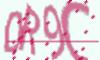

In [11]:
# 测试验证码
code = getCode()
print code
captcha.generate_image(code)

In [12]:
# 定义输入输出
x = tf.placeholder(tf.float32, shape=[None, imageSize])
y = tf.placeholder(tf.float32, shape=[None, len(charset) * captchaLength])
keep_prob = tf.placeholder(tf.float32)
x_image = tf.reshape(x, shape=[-1, width, height, 1])

In [13]:
# 定义第一层卷积
conv_layer1_weight = weight_variable([5, 5, 1, 32])
conv_layer1_bias = bias_variable([32])
pool_layer1 = max_pool(
    tf.nn.relu(conv2d(x_image, conv_layer1_weight) + conv_layer1_bias))

In [14]:
# 定义第二层卷积
conv_layer2_weight = weight_variable([5, 5, 32, 64])
conv_layer2_bias = bias_variable([64])
pool_layer2 = max_pool(
    tf.nn.relu(conv2d(pool_layer1, conv_layer2_weight) + conv_layer2_bias)) 

In [15]:
# 定义第三层卷积
conv_layer3_weight = weight_variable([5, 5, 64, 64])
conv_layer3_bias = bias_variable([64])
pool_layer3 = max_pool(
    tf.nn.relu(conv2d(pool_layer2, conv_layer3_weight) + conv_layer3_bias))

In [16]:
lastWidth = int(round(width / 8))
lastHeight = int(round(height / 8))

In [17]:
# 定义全连接层
fc_layer_weight = weight_variable([lastWidth * lastHeight * 64, 1024])
fc_layer_bias = bias_variable([1024])
pool_layer3_flat = tf.reshape(pool_layer3, [-1, lastWidth * lastHeight * 64])
fc_layer = tf.nn.relu(tf.add(tf.matmul(pool_layer3_flat, fc_layer_weight), fc_layer_bias))

In [18]:
# Dropout层
fc_layer_drop = tf.nn.dropout(fc_layer, keep_prob)

In [19]:
# Readout层
output_layer_weight = weight_variable([1024, len(charset) * captchaLength])
output_layer_bias = bias_variable([len(charset) * captchaLength])
y_conv = tf.add(tf.matmul(fc_layer_drop, output_layer_weight), output_layer_bias)

In [20]:
# 定义输出函数
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_conv))
optimizer = tf.train.AdamOptimizer(alpha).minimize(loss)
prediction = tf.argmax(tf.reshape(y_conv, [-1, captchaLength, len(charset)]), 2)
correct = tf.argmax(tf.reshape(y, [-1, captchaLength, len(charset)]), 2)                                                           
correct_prediction = tf.equal(prediction, correct)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [21]:
# 初始化session
saver = tf.train.Saver()
session = tf.Session()
session.run(tf.global_variables_initializer())

In [ ]:
for step in range(1, 10000 * 2):
    imageList, codeList = getData(100)
    x_data = map(imageToVertor, imageList)
    y_data = map(codeToVertor, codeList)
    _, l, a = session.run([optimizer, loss, accuracy], feed_dict={x: x_data, y: y_data, keep_prob: .75})
    saver.save(session, 'model/model', global_step=step)
    print '[%d]: loss: %f accuracy: %f' % (step, l, a)

[1]: loss: 0.078770 accuracy: 0.420000
[2]: loss: 0.076421 accuracy: 0.445000
[3]: loss: 0.074678 accuracy: 0.442500
[4]: loss: 0.073360 accuracy: 0.455000
[5]: loss: 0.075654 accuracy: 0.495000
[6]: loss: 0.073914 accuracy: 0.495000
[7]: loss: 0.072176 accuracy: 0.480000
[8]: loss: 0.074733 accuracy: 0.465000
[9]: loss: 0.071742 accuracy: 0.490000
[10]: loss: 0.075320 accuracy: 0.475000
[11]: loss: 0.075558 accuracy: 0.485000
[12]: loss: 0.074145 accuracy: 0.440000
[13]: loss: 0.075082 accuracy: 0.455000
[14]: loss: 0.073236 accuracy: 0.492500
[15]: loss: 0.078370 accuracy: 0.447500
[16]: loss: 0.077969 accuracy: 0.435000
[17]: loss: 0.071744 accuracy: 0.457500
[18]: loss: 0.074400 accuracy: 0.500000
[19]: loss: 0.073751 accuracy: 0.480000
[20]: loss: 0.073286 accuracy: 0.472500
[21]: loss: 0.074344 accuracy: 0.480000
[22]: loss: 0.075662 accuracy: 0.442500
[23]: loss: 0.077251 accuracy: 0.450000
[24]: loss: 0.079740 accuracy: 0.422500
[25]: loss: 0.075466 accuracy: 0.460000
[26]: los

[204]: loss: 0.077253 accuracy: 0.427500
[205]: loss: 0.073771 accuracy: 0.475000
[206]: loss: 0.077326 accuracy: 0.470000
[207]: loss: 0.070525 accuracy: 0.495000
[208]: loss: 0.072544 accuracy: 0.470000
[209]: loss: 0.075625 accuracy: 0.462500
[210]: loss: 0.075139 accuracy: 0.455000
[211]: loss: 0.074819 accuracy: 0.462500
[212]: loss: 0.076461 accuracy: 0.452500
[213]: loss: 0.071475 accuracy: 0.497500
[214]: loss: 0.075617 accuracy: 0.462500
[215]: loss: 0.075085 accuracy: 0.482500
[216]: loss: 0.077289 accuracy: 0.442500
[217]: loss: 0.075444 accuracy: 0.487500
[218]: loss: 0.073581 accuracy: 0.457500
[219]: loss: 0.071138 accuracy: 0.530000
[220]: loss: 0.073080 accuracy: 0.457500
[221]: loss: 0.067526 accuracy: 0.505000
[222]: loss: 0.075424 accuracy: 0.487500
[223]: loss: 0.077380 accuracy: 0.447500
[224]: loss: 0.072403 accuracy: 0.472500
[225]: loss: 0.073806 accuracy: 0.457500
[226]: loss: 0.072640 accuracy: 0.475000
[227]: loss: 0.072327 accuracy: 0.497500
[228]: loss: 0.0

[404]: loss: 0.074686 accuracy: 0.415000
[405]: loss: 0.080123 accuracy: 0.405000
[406]: loss: 0.079707 accuracy: 0.410000
[407]: loss: 0.075859 accuracy: 0.470000
[408]: loss: 0.075824 accuracy: 0.500000
[409]: loss: 0.071108 accuracy: 0.490000
[410]: loss: 0.072029 accuracy: 0.487500
[411]: loss: 0.075745 accuracy: 0.452500
[412]: loss: 0.075936 accuracy: 0.427500
[413]: loss: 0.075217 accuracy: 0.467500
[414]: loss: 0.075802 accuracy: 0.500000
[415]: loss: 0.076383 accuracy: 0.430000
[416]: loss: 0.072837 accuracy: 0.507500
[417]: loss: 0.073295 accuracy: 0.505000
[418]: loss: 0.071670 accuracy: 0.495000
[419]: loss: 0.075404 accuracy: 0.427500
[420]: loss: 0.078990 accuracy: 0.420000
[421]: loss: 0.075767 accuracy: 0.435000
[422]: loss: 0.072202 accuracy: 0.460000
[423]: loss: 0.071350 accuracy: 0.467500
[424]: loss: 0.079483 accuracy: 0.430000
[425]: loss: 0.076691 accuracy: 0.455000
[426]: loss: 0.076626 accuracy: 0.422500
[427]: loss: 0.076775 accuracy: 0.427500
[428]: loss: 0.0

[604]: loss: 0.073637 accuracy: 0.507500
[605]: loss: 0.077802 accuracy: 0.435000
[606]: loss: 0.074610 accuracy: 0.462500
[607]: loss: 0.075163 accuracy: 0.440000
[608]: loss: 0.074660 accuracy: 0.477500
[609]: loss: 0.078439 accuracy: 0.437500
[610]: loss: 0.075887 accuracy: 0.462500
[611]: loss: 0.074739 accuracy: 0.485000
[612]: loss: 0.078375 accuracy: 0.427500
[613]: loss: 0.076332 accuracy: 0.457500
[614]: loss: 0.076243 accuracy: 0.462500
[615]: loss: 0.073950 accuracy: 0.502500
[616]: loss: 0.079336 accuracy: 0.402500
[617]: loss: 0.074864 accuracy: 0.457500
[618]: loss: 0.075252 accuracy: 0.482500
[619]: loss: 0.078794 accuracy: 0.410000
[620]: loss: 0.075825 accuracy: 0.440000
[621]: loss: 0.073978 accuracy: 0.437500
[622]: loss: 0.072737 accuracy: 0.497500
[623]: loss: 0.074705 accuracy: 0.490000
[624]: loss: 0.070556 accuracy: 0.492500
[625]: loss: 0.074980 accuracy: 0.427500
[626]: loss: 0.076330 accuracy: 0.452500
[627]: loss: 0.075138 accuracy: 0.460000
[628]: loss: 0.0

[804]: loss: 0.073731 accuracy: 0.477500
[805]: loss: 0.080289 accuracy: 0.430000
[806]: loss: 0.071484 accuracy: 0.475000
[807]: loss: 0.078488 accuracy: 0.402500
[808]: loss: 0.076359 accuracy: 0.447500
[809]: loss: 0.075715 accuracy: 0.455000
[810]: loss: 0.074067 accuracy: 0.467500
[811]: loss: 0.076025 accuracy: 0.457500
[812]: loss: 0.076767 accuracy: 0.447500
[813]: loss: 0.077674 accuracy: 0.462500
[814]: loss: 0.077865 accuracy: 0.455000
[815]: loss: 0.077174 accuracy: 0.460000
[816]: loss: 0.074443 accuracy: 0.460000
[817]: loss: 0.077167 accuracy: 0.420000
[818]: loss: 0.071544 accuracy: 0.495000
[819]: loss: 0.075696 accuracy: 0.452500
[820]: loss: 0.078520 accuracy: 0.425000
[821]: loss: 0.076654 accuracy: 0.437500
[822]: loss: 0.073001 accuracy: 0.495000
[823]: loss: 0.077919 accuracy: 0.430000
[824]: loss: 0.075718 accuracy: 0.452500
[825]: loss: 0.074246 accuracy: 0.500000
[826]: loss: 0.072044 accuracy: 0.472500
[827]: loss: 0.075590 accuracy: 0.445000
[828]: loss: 0.0

[1004]: loss: 0.073534 accuracy: 0.472500
[1005]: loss: 0.076002 accuracy: 0.457500
[1006]: loss: 0.070924 accuracy: 0.530000
[1007]: loss: 0.075392 accuracy: 0.462500
[1008]: loss: 0.072587 accuracy: 0.517500
[1009]: loss: 0.073416 accuracy: 0.455000
[1010]: loss: 0.073476 accuracy: 0.470000
[1011]: loss: 0.072675 accuracy: 0.517500
[1012]: loss: 0.075654 accuracy: 0.455000
[1013]: loss: 0.078938 accuracy: 0.452500
[1014]: loss: 0.073341 accuracy: 0.492500
[1015]: loss: 0.076817 accuracy: 0.430000
[1016]: loss: 0.075986 accuracy: 0.455000
[1017]: loss: 0.075218 accuracy: 0.450000
[1018]: loss: 0.072360 accuracy: 0.472500
[1019]: loss: 0.080020 accuracy: 0.422500
[1020]: loss: 0.076393 accuracy: 0.457500
[1021]: loss: 0.071225 accuracy: 0.477500
[1022]: loss: 0.077296 accuracy: 0.437500
[1023]: loss: 0.074100 accuracy: 0.465000
[1024]: loss: 0.074975 accuracy: 0.467500
[1025]: loss: 0.079876 accuracy: 0.417500
[1026]: loss: 0.073360 accuracy: 0.467500
[1027]: loss: 0.073928 accuracy: 0

[1200]: loss: 0.076529 accuracy: 0.450000
[1201]: loss: 0.070181 accuracy: 0.502500
[1202]: loss: 0.077238 accuracy: 0.452500
[1203]: loss: 0.078247 accuracy: 0.402500
[1204]: loss: 0.073142 accuracy: 0.520000
[1205]: loss: 0.071747 accuracy: 0.497500
[1206]: loss: 0.074304 accuracy: 0.472500
[1207]: loss: 0.074453 accuracy: 0.435000
[1208]: loss: 0.074219 accuracy: 0.460000
[1209]: loss: 0.074645 accuracy: 0.485000
[1210]: loss: 0.077616 accuracy: 0.457500
[1211]: loss: 0.071853 accuracy: 0.472500
[1212]: loss: 0.073193 accuracy: 0.480000
[1213]: loss: 0.078259 accuracy: 0.437500
[1214]: loss: 0.070439 accuracy: 0.462500
[1215]: loss: 0.074443 accuracy: 0.462500
[1216]: loss: 0.076097 accuracy: 0.445000
[1217]: loss: 0.077014 accuracy: 0.435000
[1218]: loss: 0.074287 accuracy: 0.477500
[1219]: loss: 0.074931 accuracy: 0.482500
[1220]: loss: 0.074439 accuracy: 0.467500
[1221]: loss: 0.079528 accuracy: 0.465000
[1222]: loss: 0.071551 accuracy: 0.475000
[1223]: loss: 0.074321 accuracy: 0

[1396]: loss: 0.076211 accuracy: 0.417500
[1397]: loss: 0.074318 accuracy: 0.447500
[1398]: loss: 0.070983 accuracy: 0.497500
[1399]: loss: 0.074402 accuracy: 0.455000
[1400]: loss: 0.070732 accuracy: 0.515000
[1401]: loss: 0.077744 accuracy: 0.452500
[1402]: loss: 0.075944 accuracy: 0.470000
[1403]: loss: 0.073440 accuracy: 0.470000
[1404]: loss: 0.076622 accuracy: 0.445000
[1405]: loss: 0.072827 accuracy: 0.480000
[1406]: loss: 0.075177 accuracy: 0.435000
[1407]: loss: 0.074698 accuracy: 0.465000
[1408]: loss: 0.075326 accuracy: 0.460000
[1409]: loss: 0.073024 accuracy: 0.510000
[1410]: loss: 0.074725 accuracy: 0.450000
[1411]: loss: 0.076311 accuracy: 0.430000
[1412]: loss: 0.075339 accuracy: 0.467500
[1413]: loss: 0.074776 accuracy: 0.465000
[1414]: loss: 0.075238 accuracy: 0.485000
[1415]: loss: 0.074884 accuracy: 0.450000
[1416]: loss: 0.073057 accuracy: 0.485000
[1417]: loss: 0.073611 accuracy: 0.452500
[1418]: loss: 0.076239 accuracy: 0.442500
[1419]: loss: 0.076026 accuracy: 0

[1592]: loss: 0.072296 accuracy: 0.512500
[1593]: loss: 0.074885 accuracy: 0.445000
[1594]: loss: 0.070945 accuracy: 0.500000
[1595]: loss: 0.073086 accuracy: 0.477500
[1596]: loss: 0.072125 accuracy: 0.495000
[1597]: loss: 0.074322 accuracy: 0.467500
[1598]: loss: 0.075327 accuracy: 0.460000
[1599]: loss: 0.076053 accuracy: 0.470000
[1600]: loss: 0.068891 accuracy: 0.507500
[1601]: loss: 0.080692 accuracy: 0.427500
[1602]: loss: 0.069203 accuracy: 0.512500
[1603]: loss: 0.073501 accuracy: 0.477500
[1604]: loss: 0.074992 accuracy: 0.472500
[1605]: loss: 0.076788 accuracy: 0.482500
[1606]: loss: 0.075124 accuracy: 0.457500
[1607]: loss: 0.076926 accuracy: 0.457500
[1608]: loss: 0.069188 accuracy: 0.555000
[1609]: loss: 0.074288 accuracy: 0.500000
[1610]: loss: 0.072880 accuracy: 0.470000
[1611]: loss: 0.073257 accuracy: 0.500000
[1612]: loss: 0.077316 accuracy: 0.477500
[1613]: loss: 0.077248 accuracy: 0.460000
[1614]: loss: 0.070889 accuracy: 0.492500
[1615]: loss: 0.075020 accuracy: 0

[1788]: loss: 0.076850 accuracy: 0.420000
[1789]: loss: 0.072892 accuracy: 0.485000
[1790]: loss: 0.075431 accuracy: 0.452500
[1791]: loss: 0.078212 accuracy: 0.447500
[1792]: loss: 0.074938 accuracy: 0.440000
[1793]: loss: 0.071475 accuracy: 0.507500
[1794]: loss: 0.072481 accuracy: 0.480000
[1795]: loss: 0.076838 accuracy: 0.447500
[1796]: loss: 0.080901 accuracy: 0.425000
[1797]: loss: 0.077567 accuracy: 0.427500
[1798]: loss: 0.075483 accuracy: 0.472500
[1799]: loss: 0.077866 accuracy: 0.425000
[1800]: loss: 0.073516 accuracy: 0.485000
[1801]: loss: 0.074483 accuracy: 0.492500
[1802]: loss: 0.075962 accuracy: 0.450000
[1803]: loss: 0.072492 accuracy: 0.492500
[1804]: loss: 0.070914 accuracy: 0.472500
[1805]: loss: 0.072534 accuracy: 0.482500
[1806]: loss: 0.071685 accuracy: 0.487500
[1807]: loss: 0.072595 accuracy: 0.495000
[1808]: loss: 0.073838 accuracy: 0.482500
[1809]: loss: 0.076070 accuracy: 0.450000
[1810]: loss: 0.072046 accuracy: 0.460000
[1811]: loss: 0.074462 accuracy: 0

[1984]: loss: 0.072091 accuracy: 0.472500
[1985]: loss: 0.076848 accuracy: 0.467500
[1986]: loss: 0.070263 accuracy: 0.505000
[1987]: loss: 0.076300 accuracy: 0.462500
[1988]: loss: 0.071934 accuracy: 0.465000
[1989]: loss: 0.073842 accuracy: 0.467500
[1990]: loss: 0.072833 accuracy: 0.465000
[1991]: loss: 0.075748 accuracy: 0.432500
[1992]: loss: 0.074982 accuracy: 0.452500
[1993]: loss: 0.073027 accuracy: 0.480000
[1994]: loss: 0.075202 accuracy: 0.455000
[1995]: loss: 0.073695 accuracy: 0.475000
[1996]: loss: 0.076870 accuracy: 0.450000
[1997]: loss: 0.074366 accuracy: 0.457500
[1998]: loss: 0.075605 accuracy: 0.460000
[1999]: loss: 0.075797 accuracy: 0.447500
[2000]: loss: 0.074423 accuracy: 0.475000
[2001]: loss: 0.077789 accuracy: 0.450000
[2002]: loss: 0.072184 accuracy: 0.460000
[2003]: loss: 0.072446 accuracy: 0.455000
[2004]: loss: 0.074451 accuracy: 0.482500
[2005]: loss: 0.072597 accuracy: 0.462500
[2006]: loss: 0.074521 accuracy: 0.485000
[2007]: loss: 0.072676 accuracy: 0

[2180]: loss: 0.074123 accuracy: 0.497500
[2181]: loss: 0.074101 accuracy: 0.490000
[2182]: loss: 0.077599 accuracy: 0.437500
[2183]: loss: 0.074360 accuracy: 0.450000
[2184]: loss: 0.070083 accuracy: 0.490000
[2185]: loss: 0.073339 accuracy: 0.485000
[2186]: loss: 0.072108 accuracy: 0.507500
[2187]: loss: 0.076019 accuracy: 0.487500
[2188]: loss: 0.074175 accuracy: 0.480000
[2189]: loss: 0.075480 accuracy: 0.480000
[2190]: loss: 0.073061 accuracy: 0.467500
[2191]: loss: 0.067292 accuracy: 0.540000
[2192]: loss: 0.075680 accuracy: 0.455000
[2193]: loss: 0.075778 accuracy: 0.482500
[2194]: loss: 0.072711 accuracy: 0.475000
[2195]: loss: 0.074206 accuracy: 0.455000
[2196]: loss: 0.075078 accuracy: 0.457500
[2197]: loss: 0.073386 accuracy: 0.472500
[2198]: loss: 0.076416 accuracy: 0.480000
[2199]: loss: 0.075299 accuracy: 0.472500
[2200]: loss: 0.074031 accuracy: 0.487500
[2201]: loss: 0.075086 accuracy: 0.475000
[2202]: loss: 0.070478 accuracy: 0.525000
[2203]: loss: 0.073425 accuracy: 0

[2376]: loss: 0.074311 accuracy: 0.440000
[2377]: loss: 0.077024 accuracy: 0.465000
[2378]: loss: 0.076859 accuracy: 0.455000
[2379]: loss: 0.074066 accuracy: 0.500000
[2380]: loss: 0.073392 accuracy: 0.485000
[2381]: loss: 0.077663 accuracy: 0.425000
[2382]: loss: 0.077320 accuracy: 0.450000
[2383]: loss: 0.076551 accuracy: 0.467500
[2384]: loss: 0.071662 accuracy: 0.482500
[2385]: loss: 0.068694 accuracy: 0.527500
[2386]: loss: 0.073159 accuracy: 0.455000
[2387]: loss: 0.076948 accuracy: 0.462500
[2388]: loss: 0.076512 accuracy: 0.455000
[2389]: loss: 0.072588 accuracy: 0.477500
[2390]: loss: 0.073896 accuracy: 0.492500
[2391]: loss: 0.075715 accuracy: 0.407500
[2392]: loss: 0.075475 accuracy: 0.445000
[2393]: loss: 0.074196 accuracy: 0.477500
[2394]: loss: 0.071545 accuracy: 0.482500
[2395]: loss: 0.073132 accuracy: 0.495000
[2396]: loss: 0.073423 accuracy: 0.502500
[2397]: loss: 0.071172 accuracy: 0.512500
[2398]: loss: 0.072959 accuracy: 0.487500
[2399]: loss: 0.077941 accuracy: 0

[2572]: loss: 0.072797 accuracy: 0.465000
[2573]: loss: 0.082047 accuracy: 0.427500
[2574]: loss: 0.072371 accuracy: 0.487500
[2575]: loss: 0.076847 accuracy: 0.477500
[2576]: loss: 0.073980 accuracy: 0.470000
[2577]: loss: 0.073022 accuracy: 0.470000
[2578]: loss: 0.070507 accuracy: 0.505000
[2579]: loss: 0.075588 accuracy: 0.450000
[2580]: loss: 0.073222 accuracy: 0.457500
[2581]: loss: 0.074310 accuracy: 0.460000
[2582]: loss: 0.073328 accuracy: 0.482500
[2583]: loss: 0.073952 accuracy: 0.472500
[2584]: loss: 0.074953 accuracy: 0.475000
[2585]: loss: 0.075470 accuracy: 0.452500
[2586]: loss: 0.075691 accuracy: 0.445000
[2587]: loss: 0.076685 accuracy: 0.445000
[2588]: loss: 0.074766 accuracy: 0.440000
[2589]: loss: 0.074462 accuracy: 0.462500
[2590]: loss: 0.073994 accuracy: 0.475000
[2591]: loss: 0.076552 accuracy: 0.445000
[2592]: loss: 0.076372 accuracy: 0.447500
[2593]: loss: 0.077536 accuracy: 0.420000
[2594]: loss: 0.073689 accuracy: 0.470000
[2595]: loss: 0.069042 accuracy: 0

[2768]: loss: 0.070417 accuracy: 0.475000
[2769]: loss: 0.071342 accuracy: 0.505000
[2770]: loss: 0.077037 accuracy: 0.477500
[2771]: loss: 0.076741 accuracy: 0.435000
[2772]: loss: 0.078503 accuracy: 0.427500
[2773]: loss: 0.069768 accuracy: 0.525000
[2774]: loss: 0.071930 accuracy: 0.490000
[2775]: loss: 0.072876 accuracy: 0.477500
[2776]: loss: 0.076935 accuracy: 0.437500
[2777]: loss: 0.074618 accuracy: 0.435000
[2778]: loss: 0.078761 accuracy: 0.417500
[2779]: loss: 0.075388 accuracy: 0.437500
[2780]: loss: 0.072864 accuracy: 0.472500
[2781]: loss: 0.076323 accuracy: 0.457500
[2782]: loss: 0.073291 accuracy: 0.460000
[2783]: loss: 0.072766 accuracy: 0.460000
[2784]: loss: 0.073708 accuracy: 0.462500
[2785]: loss: 0.077163 accuracy: 0.475000
[2786]: loss: 0.073529 accuracy: 0.485000
[2787]: loss: 0.080018 accuracy: 0.417500
[2788]: loss: 0.073890 accuracy: 0.487500
[2789]: loss: 0.074534 accuracy: 0.455000
[2790]: loss: 0.073859 accuracy: 0.497500
[2791]: loss: 0.073063 accuracy: 0

[2964]: loss: 0.071500 accuracy: 0.467500
[2965]: loss: 0.074528 accuracy: 0.475000
[2966]: loss: 0.076095 accuracy: 0.477500
[2967]: loss: 0.074656 accuracy: 0.450000
[2968]: loss: 0.073846 accuracy: 0.462500
[2969]: loss: 0.074809 accuracy: 0.472500
[2970]: loss: 0.070326 accuracy: 0.495000
[2971]: loss: 0.073923 accuracy: 0.470000
[2972]: loss: 0.070021 accuracy: 0.510000
[2973]: loss: 0.073985 accuracy: 0.440000
[2974]: loss: 0.071616 accuracy: 0.480000
[2975]: loss: 0.078344 accuracy: 0.420000
[2976]: loss: 0.074755 accuracy: 0.467500
[2977]: loss: 0.072078 accuracy: 0.507500
[2978]: loss: 0.076120 accuracy: 0.442500
[2979]: loss: 0.076108 accuracy: 0.460000
[2980]: loss: 0.078382 accuracy: 0.447500
[2981]: loss: 0.070904 accuracy: 0.487500
[2982]: loss: 0.074795 accuracy: 0.457500
[2983]: loss: 0.075256 accuracy: 0.435000
[2984]: loss: 0.075123 accuracy: 0.450000
[2985]: loss: 0.072272 accuracy: 0.500000
[2986]: loss: 0.074872 accuracy: 0.475000
[2987]: loss: 0.076804 accuracy: 0

[3160]: loss: 0.073978 accuracy: 0.490000
[3161]: loss: 0.070420 accuracy: 0.507500
[3162]: loss: 0.075385 accuracy: 0.460000
[3163]: loss: 0.073980 accuracy: 0.462500
[3164]: loss: 0.072905 accuracy: 0.432500
[3165]: loss: 0.074380 accuracy: 0.470000
[3166]: loss: 0.074411 accuracy: 0.500000
[3167]: loss: 0.072942 accuracy: 0.477500
[3168]: loss: 0.076422 accuracy: 0.430000
[3169]: loss: 0.075108 accuracy: 0.445000
[3170]: loss: 0.075606 accuracy: 0.447500
[3171]: loss: 0.072786 accuracy: 0.495000
[3172]: loss: 0.073518 accuracy: 0.485000
[3173]: loss: 0.078032 accuracy: 0.432500
[3174]: loss: 0.074481 accuracy: 0.465000
[3175]: loss: 0.073338 accuracy: 0.492500
[3176]: loss: 0.069396 accuracy: 0.530000
[3177]: loss: 0.075941 accuracy: 0.455000
[3178]: loss: 0.077975 accuracy: 0.455000
[3179]: loss: 0.077647 accuracy: 0.445000
[3180]: loss: 0.077667 accuracy: 0.425000
[3181]: loss: 0.070568 accuracy: 0.507500
[3182]: loss: 0.075898 accuracy: 0.442500
[3183]: loss: 0.075532 accuracy: 0

[3356]: loss: 0.071136 accuracy: 0.517500
[3357]: loss: 0.070522 accuracy: 0.510000
[3358]: loss: 0.076130 accuracy: 0.432500
[3359]: loss: 0.075017 accuracy: 0.482500
[3360]: loss: 0.076063 accuracy: 0.460000
[3361]: loss: 0.073713 accuracy: 0.482500
[3362]: loss: 0.069961 accuracy: 0.510000
[3363]: loss: 0.077695 accuracy: 0.450000
[3364]: loss: 0.074819 accuracy: 0.485000
[3365]: loss: 0.075181 accuracy: 0.470000
[3366]: loss: 0.073884 accuracy: 0.462500
[3367]: loss: 0.079457 accuracy: 0.440000
[3368]: loss: 0.072224 accuracy: 0.477500
[3369]: loss: 0.073074 accuracy: 0.505000
[3370]: loss: 0.073100 accuracy: 0.465000
[3371]: loss: 0.073794 accuracy: 0.497500
[3372]: loss: 0.074624 accuracy: 0.490000
[3373]: loss: 0.079448 accuracy: 0.465000
[3374]: loss: 0.074299 accuracy: 0.500000
[3375]: loss: 0.069541 accuracy: 0.512500
[3376]: loss: 0.074466 accuracy: 0.467500
[3377]: loss: 0.074981 accuracy: 0.432500
[3378]: loss: 0.071953 accuracy: 0.480000
[3379]: loss: 0.075448 accuracy: 0

[3552]: loss: 0.077180 accuracy: 0.452500
[3553]: loss: 0.077042 accuracy: 0.427500
[3554]: loss: 0.074927 accuracy: 0.487500
[3555]: loss: 0.073718 accuracy: 0.475000
[3556]: loss: 0.073986 accuracy: 0.500000
[3557]: loss: 0.079011 accuracy: 0.415000
[3558]: loss: 0.077332 accuracy: 0.440000
[3559]: loss: 0.073355 accuracy: 0.452500
[3560]: loss: 0.073426 accuracy: 0.452500
[3561]: loss: 0.071736 accuracy: 0.465000
[3562]: loss: 0.073812 accuracy: 0.492500
[3563]: loss: 0.074085 accuracy: 0.465000
[3564]: loss: 0.072465 accuracy: 0.500000
[3565]: loss: 0.071917 accuracy: 0.492500
[3566]: loss: 0.072935 accuracy: 0.482500
[3567]: loss: 0.076519 accuracy: 0.397500
[3568]: loss: 0.069995 accuracy: 0.487500
[3569]: loss: 0.075864 accuracy: 0.470000
[3570]: loss: 0.078296 accuracy: 0.452500
[3571]: loss: 0.078833 accuracy: 0.430000
[3572]: loss: 0.069601 accuracy: 0.527500
[3573]: loss: 0.076031 accuracy: 0.460000
[3574]: loss: 0.071993 accuracy: 0.460000
[3575]: loss: 0.075935 accuracy: 0

[3748]: loss: 0.074597 accuracy: 0.475000
[3749]: loss: 0.073964 accuracy: 0.447500
[3750]: loss: 0.073733 accuracy: 0.450000
[3751]: loss: 0.072968 accuracy: 0.475000
[3752]: loss: 0.071748 accuracy: 0.475000
[3753]: loss: 0.074489 accuracy: 0.442500
[3754]: loss: 0.073794 accuracy: 0.497500
[3755]: loss: 0.073957 accuracy: 0.442500
[3756]: loss: 0.073477 accuracy: 0.475000
[3757]: loss: 0.076591 accuracy: 0.467500
[3758]: loss: 0.075015 accuracy: 0.462500
[3759]: loss: 0.077342 accuracy: 0.445000
[3760]: loss: 0.072503 accuracy: 0.472500
[3761]: loss: 0.075545 accuracy: 0.472500
[3762]: loss: 0.075962 accuracy: 0.485000
[3763]: loss: 0.074290 accuracy: 0.465000
[3764]: loss: 0.070464 accuracy: 0.520000
[3765]: loss: 0.074505 accuracy: 0.467500
[3766]: loss: 0.073028 accuracy: 0.482500
[3767]: loss: 0.074408 accuracy: 0.437500
[3768]: loss: 0.073005 accuracy: 0.512500
[3769]: loss: 0.076090 accuracy: 0.442500
[3770]: loss: 0.072672 accuracy: 0.487500
[3771]: loss: 0.081967 accuracy: 0

[3944]: loss: 0.070058 accuracy: 0.497500
[3945]: loss: 0.072858 accuracy: 0.445000
[3946]: loss: 0.069059 accuracy: 0.497500
[3947]: loss: 0.072570 accuracy: 0.482500
[3948]: loss: 0.074643 accuracy: 0.485000
[3949]: loss: 0.070813 accuracy: 0.522500
[3950]: loss: 0.074685 accuracy: 0.440000
[3951]: loss: 0.075371 accuracy: 0.490000
[3952]: loss: 0.071870 accuracy: 0.512500
[3953]: loss: 0.075606 accuracy: 0.460000
[3954]: loss: 0.076358 accuracy: 0.447500
[3955]: loss: 0.071874 accuracy: 0.495000
[3956]: loss: 0.070228 accuracy: 0.487500
[3957]: loss: 0.072888 accuracy: 0.487500
[3958]: loss: 0.078132 accuracy: 0.455000
[3959]: loss: 0.070817 accuracy: 0.497500
[3960]: loss: 0.076947 accuracy: 0.462500
[3961]: loss: 0.072126 accuracy: 0.467500
[3962]: loss: 0.076586 accuracy: 0.432500
[3963]: loss: 0.073734 accuracy: 0.500000
[3964]: loss: 0.073353 accuracy: 0.507500
[3965]: loss: 0.073090 accuracy: 0.470000
[3966]: loss: 0.075725 accuracy: 0.420000
[3967]: loss: 0.072334 accuracy: 0

[4140]: loss: 0.072404 accuracy: 0.465000
[4141]: loss: 0.076687 accuracy: 0.435000
[4142]: loss: 0.074467 accuracy: 0.460000
[4143]: loss: 0.073917 accuracy: 0.455000
[4144]: loss: 0.071979 accuracy: 0.502500
[4145]: loss: 0.076306 accuracy: 0.422500
[4146]: loss: 0.072696 accuracy: 0.455000
[4147]: loss: 0.076319 accuracy: 0.447500
[4148]: loss: 0.072990 accuracy: 0.485000
[4149]: loss: 0.075245 accuracy: 0.450000
[4150]: loss: 0.074785 accuracy: 0.472500
[4151]: loss: 0.077853 accuracy: 0.432500
[4152]: loss: 0.070222 accuracy: 0.497500
[4153]: loss: 0.074267 accuracy: 0.477500
[4154]: loss: 0.075203 accuracy: 0.472500
[4155]: loss: 0.075501 accuracy: 0.452500
[4156]: loss: 0.067957 accuracy: 0.497500
[4157]: loss: 0.078118 accuracy: 0.455000
[4158]: loss: 0.077622 accuracy: 0.455000
[4159]: loss: 0.075807 accuracy: 0.492500
[4160]: loss: 0.077487 accuracy: 0.442500
[4161]: loss: 0.072996 accuracy: 0.450000
[4162]: loss: 0.075988 accuracy: 0.420000
[4163]: loss: 0.077780 accuracy: 0

[4336]: loss: 0.072104 accuracy: 0.490000
[4337]: loss: 0.074408 accuracy: 0.480000
[4338]: loss: 0.071277 accuracy: 0.470000
[4339]: loss: 0.070715 accuracy: 0.487500
[4340]: loss: 0.075717 accuracy: 0.485000
[4341]: loss: 0.075150 accuracy: 0.475000
[4342]: loss: 0.075548 accuracy: 0.457500
[4343]: loss: 0.073515 accuracy: 0.507500
[4344]: loss: 0.074082 accuracy: 0.460000
[4345]: loss: 0.078859 accuracy: 0.435000
[4346]: loss: 0.071101 accuracy: 0.492500
[4347]: loss: 0.071795 accuracy: 0.515000
[4348]: loss: 0.074218 accuracy: 0.452500
[4349]: loss: 0.074076 accuracy: 0.477500
[4350]: loss: 0.075198 accuracy: 0.470000
[4351]: loss: 0.074186 accuracy: 0.482500
[4352]: loss: 0.074065 accuracy: 0.467500
[4353]: loss: 0.070986 accuracy: 0.505000
[4354]: loss: 0.076882 accuracy: 0.435000
[4355]: loss: 0.074920 accuracy: 0.457500
[4356]: loss: 0.073285 accuracy: 0.460000
[4357]: loss: 0.076592 accuracy: 0.425000
[4358]: loss: 0.071382 accuracy: 0.512500
[4359]: loss: 0.076123 accuracy: 0

[4532]: loss: 0.076160 accuracy: 0.457500
[4533]: loss: 0.071964 accuracy: 0.500000
[4534]: loss: 0.074534 accuracy: 0.477500
[4535]: loss: 0.072303 accuracy: 0.477500
[4536]: loss: 0.071483 accuracy: 0.492500
[4537]: loss: 0.072964 accuracy: 0.505000
[4538]: loss: 0.074465 accuracy: 0.465000
[4539]: loss: 0.076312 accuracy: 0.452500
[4540]: loss: 0.069572 accuracy: 0.542500
[4541]: loss: 0.072908 accuracy: 0.522500
[4542]: loss: 0.071694 accuracy: 0.540000
[4543]: loss: 0.072825 accuracy: 0.455000
[4544]: loss: 0.078660 accuracy: 0.425000
[4545]: loss: 0.076736 accuracy: 0.465000
[4546]: loss: 0.074183 accuracy: 0.487500
[4547]: loss: 0.072653 accuracy: 0.495000
[4548]: loss: 0.073857 accuracy: 0.455000
[4549]: loss: 0.072410 accuracy: 0.460000
[4550]: loss: 0.072832 accuracy: 0.465000
[4551]: loss: 0.078383 accuracy: 0.410000
[4552]: loss: 0.078311 accuracy: 0.425000
[4553]: loss: 0.070154 accuracy: 0.475000
[4554]: loss: 0.067119 accuracy: 0.520000
[4555]: loss: 0.071498 accuracy: 0

[4728]: loss: 0.072746 accuracy: 0.482500
[4729]: loss: 0.072300 accuracy: 0.477500
[4730]: loss: 0.073291 accuracy: 0.452500
[4731]: loss: 0.075133 accuracy: 0.437500
[4732]: loss: 0.074635 accuracy: 0.467500
[4733]: loss: 0.070749 accuracy: 0.522500
[4734]: loss: 0.073151 accuracy: 0.472500
[4735]: loss: 0.075137 accuracy: 0.455000
[4736]: loss: 0.067619 accuracy: 0.500000
[4737]: loss: 0.073769 accuracy: 0.490000
[4738]: loss: 0.074202 accuracy: 0.530000
[4739]: loss: 0.079300 accuracy: 0.405000
[4740]: loss: 0.069919 accuracy: 0.517500
[4741]: loss: 0.073443 accuracy: 0.470000
[4742]: loss: 0.072550 accuracy: 0.517500
[4743]: loss: 0.070815 accuracy: 0.500000
[4744]: loss: 0.072719 accuracy: 0.472500
[4745]: loss: 0.074278 accuracy: 0.465000
[4746]: loss: 0.074555 accuracy: 0.457500
[4747]: loss: 0.076561 accuracy: 0.475000
[4748]: loss: 0.073704 accuracy: 0.462500
[4749]: loss: 0.070049 accuracy: 0.497500
[4750]: loss: 0.071669 accuracy: 0.465000
[4751]: loss: 0.073613 accuracy: 0

[4924]: loss: 0.071438 accuracy: 0.497500
[4925]: loss: 0.067030 accuracy: 0.547500
[4926]: loss: 0.074345 accuracy: 0.467500
[4927]: loss: 0.073464 accuracy: 0.460000
[4928]: loss: 0.074846 accuracy: 0.452500
[4929]: loss: 0.070716 accuracy: 0.455000
[4930]: loss: 0.072758 accuracy: 0.465000
[4931]: loss: 0.074200 accuracy: 0.467500
[4932]: loss: 0.071749 accuracy: 0.497500
[4933]: loss: 0.073157 accuracy: 0.487500
[4934]: loss: 0.072710 accuracy: 0.502500
[4935]: loss: 0.076272 accuracy: 0.457500
[4936]: loss: 0.070123 accuracy: 0.495000
[4937]: loss: 0.075253 accuracy: 0.445000
[4938]: loss: 0.073383 accuracy: 0.460000
[4939]: loss: 0.072184 accuracy: 0.500000
[4940]: loss: 0.071149 accuracy: 0.467500
[4941]: loss: 0.071792 accuracy: 0.492500
[4942]: loss: 0.075765 accuracy: 0.470000
[4943]: loss: 0.072008 accuracy: 0.490000
[4944]: loss: 0.073451 accuracy: 0.457500
[4945]: loss: 0.067716 accuracy: 0.535000
[4946]: loss: 0.070927 accuracy: 0.487500
[4947]: loss: 0.070225 accuracy: 0

[5120]: loss: 0.074859 accuracy: 0.492500
[5121]: loss: 0.075104 accuracy: 0.487500
[5122]: loss: 0.068336 accuracy: 0.530000
[5123]: loss: 0.072344 accuracy: 0.472500
[5124]: loss: 0.074090 accuracy: 0.487500
[5125]: loss: 0.073226 accuracy: 0.515000
[5126]: loss: 0.078553 accuracy: 0.435000
[5127]: loss: 0.071205 accuracy: 0.490000
[5128]: loss: 0.072049 accuracy: 0.482500
[5129]: loss: 0.077836 accuracy: 0.430000
[5130]: loss: 0.069449 accuracy: 0.515000
[5131]: loss: 0.071446 accuracy: 0.502500
[5132]: loss: 0.072248 accuracy: 0.505000
[5133]: loss: 0.073073 accuracy: 0.512500
[5134]: loss: 0.074044 accuracy: 0.465000
[5135]: loss: 0.065976 accuracy: 0.535000
[5136]: loss: 0.073494 accuracy: 0.500000
[5137]: loss: 0.075540 accuracy: 0.450000
[5138]: loss: 0.069291 accuracy: 0.495000
[5139]: loss: 0.072162 accuracy: 0.482500
[5140]: loss: 0.072869 accuracy: 0.472500
[5141]: loss: 0.076110 accuracy: 0.462500
[5142]: loss: 0.075816 accuracy: 0.452500
[5143]: loss: 0.068684 accuracy: 0

[5316]: loss: 0.074069 accuracy: 0.480000
[5317]: loss: 0.076521 accuracy: 0.485000
[5318]: loss: 0.070828 accuracy: 0.505000
[5319]: loss: 0.070530 accuracy: 0.475000
[5320]: loss: 0.074610 accuracy: 0.450000
[5321]: loss: 0.072244 accuracy: 0.482500
[5322]: loss: 0.071925 accuracy: 0.480000
[5323]: loss: 0.071350 accuracy: 0.500000
[5324]: loss: 0.070242 accuracy: 0.477500
[5325]: loss: 0.072506 accuracy: 0.497500
[5326]: loss: 0.070089 accuracy: 0.532500
[5327]: loss: 0.076191 accuracy: 0.447500
[5328]: loss: 0.074117 accuracy: 0.475000
[5329]: loss: 0.070535 accuracy: 0.487500
[5330]: loss: 0.072591 accuracy: 0.490000
[5331]: loss: 0.073851 accuracy: 0.485000
[5332]: loss: 0.076890 accuracy: 0.480000
[5333]: loss: 0.070377 accuracy: 0.490000
[5334]: loss: 0.070934 accuracy: 0.507500
[5335]: loss: 0.075845 accuracy: 0.447500
[5336]: loss: 0.071922 accuracy: 0.497500
[5337]: loss: 0.070516 accuracy: 0.490000
[5338]: loss: 0.073547 accuracy: 0.467500
[5339]: loss: 0.071678 accuracy: 0

[5512]: loss: 0.072327 accuracy: 0.487500
[5513]: loss: 0.071935 accuracy: 0.430000
[5514]: loss: 0.072463 accuracy: 0.502500
[5515]: loss: 0.073149 accuracy: 0.475000
[5516]: loss: 0.068496 accuracy: 0.542500
[5517]: loss: 0.071674 accuracy: 0.482500
[5518]: loss: 0.069644 accuracy: 0.505000
[5519]: loss: 0.069026 accuracy: 0.505000
[5520]: loss: 0.072225 accuracy: 0.452500
[5521]: loss: 0.073567 accuracy: 0.490000
[5522]: loss: 0.071878 accuracy: 0.477500
[5523]: loss: 0.070439 accuracy: 0.525000
[5524]: loss: 0.066033 accuracy: 0.515000
[5525]: loss: 0.074752 accuracy: 0.462500
[5526]: loss: 0.073085 accuracy: 0.480000
[5527]: loss: 0.072779 accuracy: 0.472500
[5528]: loss: 0.068983 accuracy: 0.517500
[5529]: loss: 0.074906 accuracy: 0.460000
[5530]: loss: 0.069734 accuracy: 0.550000
[5531]: loss: 0.070785 accuracy: 0.497500
[5532]: loss: 0.074781 accuracy: 0.452500
[5533]: loss: 0.070594 accuracy: 0.522500
[5534]: loss: 0.073627 accuracy: 0.487500
[5535]: loss: 0.072368 accuracy: 0

[5708]: loss: 0.073478 accuracy: 0.475000
[5709]: loss: 0.072713 accuracy: 0.490000
[5710]: loss: 0.075053 accuracy: 0.472500
[5711]: loss: 0.076301 accuracy: 0.442500
[5712]: loss: 0.069971 accuracy: 0.507500
[5713]: loss: 0.072515 accuracy: 0.472500
[5714]: loss: 0.072555 accuracy: 0.480000
[5715]: loss: 0.071013 accuracy: 0.512500
[5716]: loss: 0.072479 accuracy: 0.477500
[5717]: loss: 0.074200 accuracy: 0.445000
[5718]: loss: 0.075438 accuracy: 0.467500
[5719]: loss: 0.068627 accuracy: 0.530000
[5720]: loss: 0.069039 accuracy: 0.505000
[5721]: loss: 0.073296 accuracy: 0.457500
[5722]: loss: 0.072416 accuracy: 0.520000
[5723]: loss: 0.068849 accuracy: 0.517500
[5724]: loss: 0.075092 accuracy: 0.437500
[5725]: loss: 0.068988 accuracy: 0.520000
[5726]: loss: 0.072100 accuracy: 0.472500
[5727]: loss: 0.072981 accuracy: 0.490000
[5728]: loss: 0.070190 accuracy: 0.507500
[5729]: loss: 0.071533 accuracy: 0.522500
[5730]: loss: 0.071048 accuracy: 0.482500
[5731]: loss: 0.074579 accuracy: 0

[5904]: loss: 0.069251 accuracy: 0.515000
[5905]: loss: 0.072275 accuracy: 0.505000
[5906]: loss: 0.073268 accuracy: 0.510000
[5907]: loss: 0.073341 accuracy: 0.500000
[5908]: loss: 0.072943 accuracy: 0.482500
[5909]: loss: 0.068606 accuracy: 0.515000
[5910]: loss: 0.072468 accuracy: 0.470000
[5911]: loss: 0.070407 accuracy: 0.502500
[5912]: loss: 0.073273 accuracy: 0.475000
[5913]: loss: 0.071626 accuracy: 0.505000
[5914]: loss: 0.075427 accuracy: 0.425000
[5915]: loss: 0.070726 accuracy: 0.492500
[5916]: loss: 0.075790 accuracy: 0.437500
[5917]: loss: 0.073162 accuracy: 0.455000
[5918]: loss: 0.071642 accuracy: 0.502500
[5919]: loss: 0.071816 accuracy: 0.497500
[5920]: loss: 0.072242 accuracy: 0.492500
[5921]: loss: 0.076124 accuracy: 0.485000
[5922]: loss: 0.071759 accuracy: 0.477500
[5923]: loss: 0.073857 accuracy: 0.507500
[5924]: loss: 0.072514 accuracy: 0.452500
[5925]: loss: 0.074492 accuracy: 0.472500
[5926]: loss: 0.072073 accuracy: 0.500000
[5927]: loss: 0.075687 accuracy: 0

[6100]: loss: 0.075385 accuracy: 0.442500
[6101]: loss: 0.073102 accuracy: 0.472500
[6102]: loss: 0.072462 accuracy: 0.492500
[6103]: loss: 0.071468 accuracy: 0.505000
[6104]: loss: 0.074080 accuracy: 0.460000
[6105]: loss: 0.074496 accuracy: 0.470000
[6106]: loss: 0.073137 accuracy: 0.450000
[6107]: loss: 0.075246 accuracy: 0.482500
[6108]: loss: 0.073708 accuracy: 0.502500
[6109]: loss: 0.071717 accuracy: 0.465000
[6110]: loss: 0.074158 accuracy: 0.455000
[6111]: loss: 0.072696 accuracy: 0.472500
[6112]: loss: 0.071612 accuracy: 0.497500
[6113]: loss: 0.070306 accuracy: 0.520000
[6114]: loss: 0.071714 accuracy: 0.447500
[6115]: loss: 0.069709 accuracy: 0.515000
[6116]: loss: 0.077119 accuracy: 0.432500
[6117]: loss: 0.072972 accuracy: 0.490000
[6118]: loss: 0.074854 accuracy: 0.442500
[6119]: loss: 0.072234 accuracy: 0.497500
[6120]: loss: 0.074279 accuracy: 0.462500
[6121]: loss: 0.067048 accuracy: 0.520000
[6122]: loss: 0.070439 accuracy: 0.500000
[6123]: loss: 0.073410 accuracy: 0

In [ ]:
#　模型效果

In [1]:
imageList, codeList = getData(1)
imageList[0]

NameError: name 'getData' is not defined

In [70]:
codeList[0]

'DKFD'

In [71]:
x_data = map(imageToVertor, imageList)
y_data = map(codeToVertor, codeList)
p, l = session.run([prediction, loss], feed_dict={x: x_data, y: y_data, keep_prob: .75})

In [72]:
print 'prediction:', map(lambda x: charset[x], p[0])
print 'loss:', l

prediction: ['C', 'X', '9', 'O']
loss: 0.0897327
